# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Useful Functions

In [2]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Create Time Series

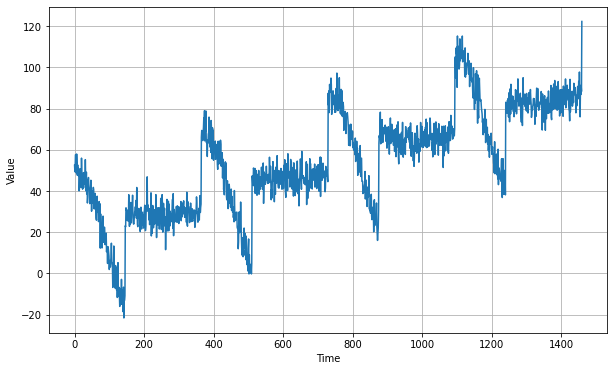

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
period = 365

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# Splitting Time Series

In [4]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Creating windowed dataset

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
dataset = windowed_dataset(x_train, 
                           window_size, 
                           batch_size=128, 
                           shuffle_buffer=shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


# **RNN Model**

# Find Learning Rate & Create Model

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_rnn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model_rnn.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
  metrics = ['mae']
)

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
history_rnn = model_rnn.fit(dataset,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 16ms/step - loss: 18.8839 - mae: 19.3793
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 18.7321 - mae: 19.2258
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 18.5070 - mae: 19.0016
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 18.2548 - mae: 18.7489
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 17.9936 - mae: 18.4883
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 17.7353 - mae: 18.2293
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 17.4858 - mae: 17.9795
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 17.2438 - mae: 17.7369
Epoch 9/100
8/8 [==============================] - 0s 14ms/step - loss: 17.0020 - mae: 17.4955
Epoch 10/100
8/8 [==============================] - 0s 16ms/step - loss: 16.7508 - mae: 17.2419
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

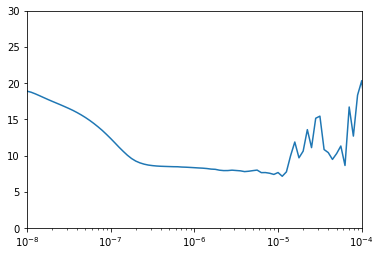

In [13]:
plt.semilogx(history_rnn.history["lr"], history_rnn.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_rnn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model_rnn.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9),
  metrics = ['mae']
)

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_rnn = model_rnn.fit(dataset,
                    epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 17ms/step - loss: 17.5197 - mae: 18.0155
Epoch 2/400
8/8 [==============================] - 0s 16ms/step - loss: 21.0808 - mae: 21.5737
Epoch 3/400
8/8 [==============================] - 0s 17ms/step - loss: 18.6199 - mae: 19.1137
Epoch 4/400
8/8 [==============================] - 0s 15ms/step - loss: 17.8754 - mae: 18.3668
Epoch 5/400
8/8 [==============================] - 0s 18ms/step - loss: 13.4411 - mae: 13.9335
Epoch 6/400
8/8 [==============================] - 0s 18ms/step - loss: 15.3391 - mae: 15.8340
Epoch 7/400
8/8 [==============================] - 0s 23ms/step - loss: 10.9535 - mae: 11.4429
Epoch 8/400
8/8 [==============================] - 0s 17ms/step - loss: 14.4349 - mae: 14.9281
Epoch 9/400
8/8 [==============================] - 0s 18ms/step - loss: 14.2026 - mae: 14.6974
Epoch 10/400
8/8 [==============================] - 0s 18ms/step - loss: 11.9064 - mae: 12.3981
Epoch 11/400
8/8 [==============================]

In [16]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model_rnn.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


print(len(results))

461


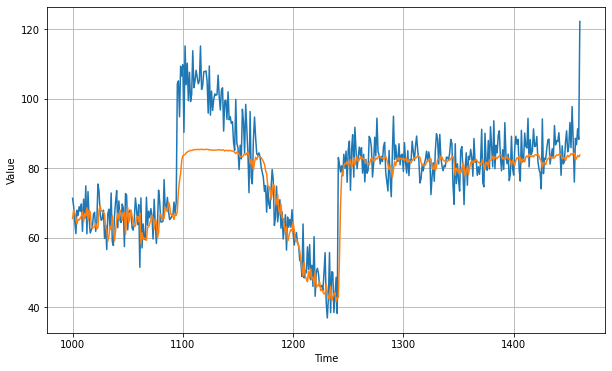

In [17]:
plt.figure(figsize=(10, 6))

plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, results)

# Loss

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.201536

# Plot Loss

<Figure size 432x288 with 0 Axes>

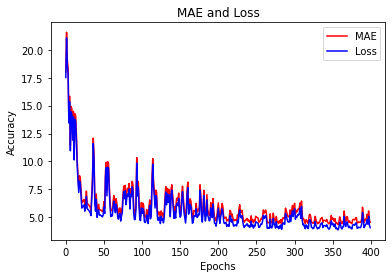

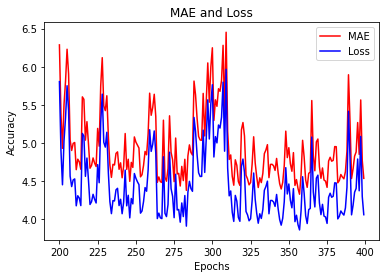

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_rnn.history['mae']
loss=history_rnn.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()